GPU: -1
# dim z: 2
# Minibatch-size: 1200
# epoch: 200



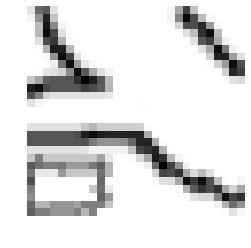

[0.64603335]


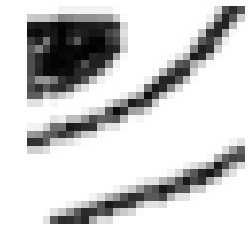

[0.07214614]


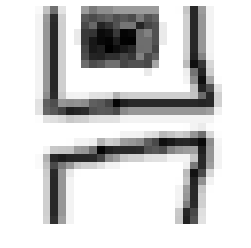

[0.44982865]


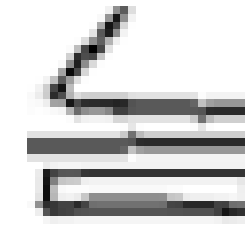

[0.2164168]


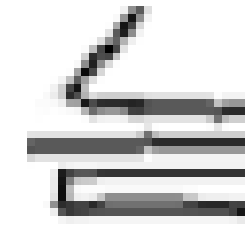

[0.20885713]


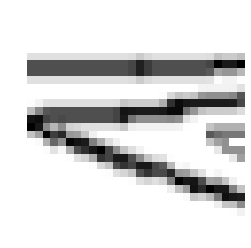

[0.79928374]


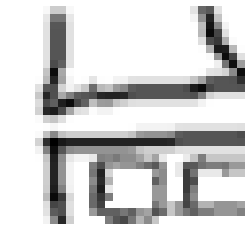

[0.56335545]


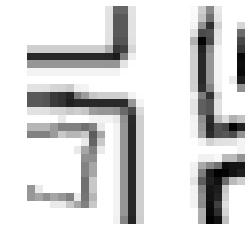

[0.96666735]


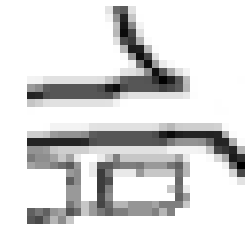

[0.60416234]


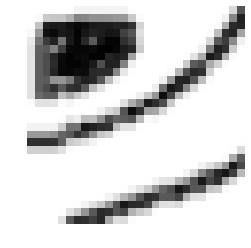

[0.06457748]
1
epoch       main/loss   validation/main/loss  main/rec_loss  validation/main/rec_loss  elapsed_time
1           495.716     394.953               490.721        388.533                   2.77369       
2           389.893     375.163               383.075        370.376                   5.09741       
3           386.223     384.057               381.909        379.234                   8.28398       
4           382.43      369.688               377.955        366.395                   10.748        
5           371.969     367.18                368.923        364.981                   13.9824       
6           368.952     362.876               366.713        360.334                   16.3022       
7           362.689     356.854               359.924        354.165                   19.241        
8           357.175     355.659               354.639        353.264                   21.6006       
9           355.943     352.393               353.46         349.781 

81          293.307     293.895               286.066        286.529                   240.575       
82          290.513     288.837               283.214        281.785                   243.088       
83          288.941     288.681               281.73         281.633                   246.202       
84          287.952     283.53                280.784        276.251                   248.838       
85          285.234     284.984               277.878        277.511                   252.069       
86          284.605     281.124               277.227        273.824                   254.452       
87          282.132     282.428               274.707        275.133                   257.526       
88          282.482     279.512               275.086        272.137                   260.004       
89          281.049     280.095               273.674        272.645                   263.007       
90          280.874     277.31                273.376        269.924              

162         255.459     252.919               246.965        244.563                   468.192       
163         253.157     252.974               244.673        244.569                   471.533       
164         254.104     252.72                245.475        244.368                   474.04        
165         252.527     250.834               244.045        242.512                   477.027       
166         253.315     253.269               244.874        244.974                   479.422       
167         255.093     252.472               246.673        244.095                   482.474       
168         252.428     250.163               243.892        241.73                    484.948       
169         251.238     251.837               242.66         243.383                   488.485       
170         253.457     251.19                244.881        242.727                   491.267       
171         250.565     248.461               242.009        240.097              

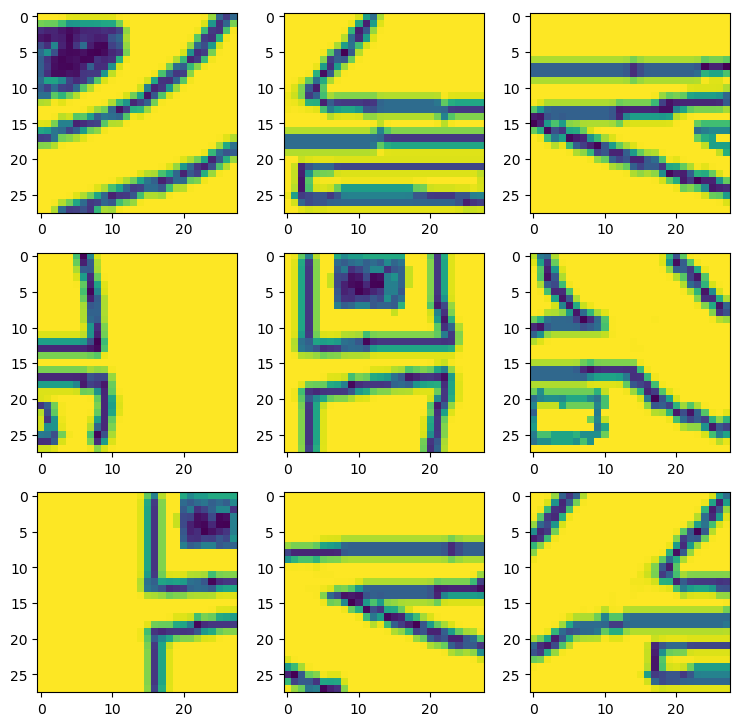

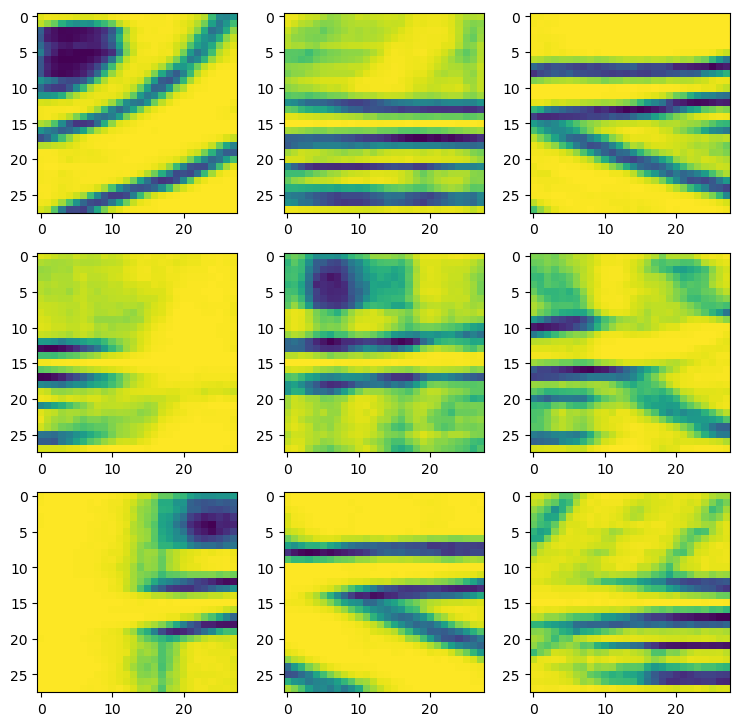

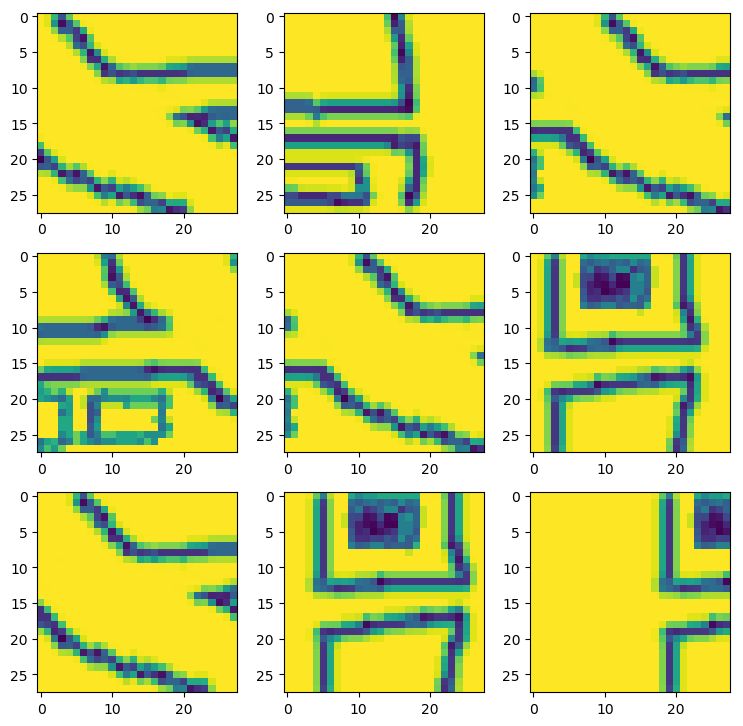

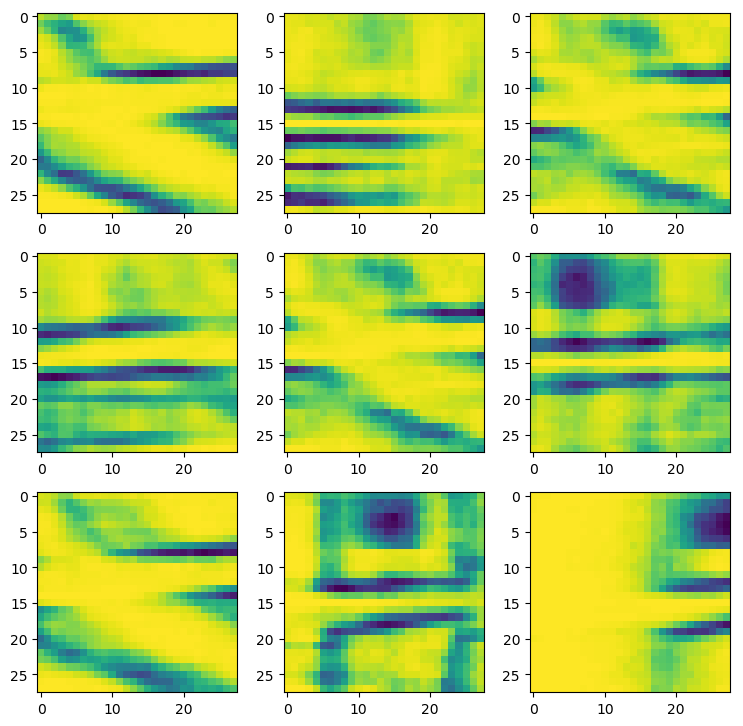

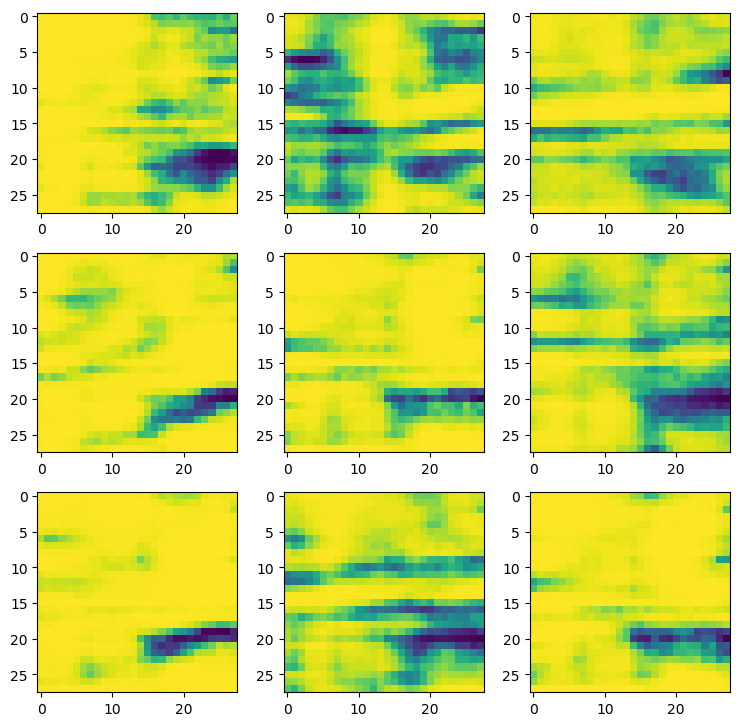

In [1]:
"""CVAE on MNIST
"""
import argparse
import os

import chainer
import pickle
import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions
from PIL import Image, ImageDraw
import numpy as np

import net 
import make_random_mnist
import make_random_selfdata
from chainer import serializers
%matplotlib inline


NLABELDIM = 1
NZDIM = 2

def load_save_random_dataset_withlabel(fname, n):
    dataset = make_random_mnist.MakeRandomMNIST()
    if os.path.exists(fname):
        with open(fname, mode='rb') as f:
            ret = pickle.load(f)
            return ret
    v = dataset.get_random_dataset_with_label(n)
    with open(fname, mode='wb') as f:
        pickle.dump(v, f)
        return v

def dispImage(img_vec):
    #title = 'Label number is ('+ str(label_x) + ',' + str(label_y) + ')' 
    pixels = (img_vec * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.axis("off")
    #plt.title(title)
    plt.show()

def main():
    global NLABELDIM, NZDIM
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=200, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=2, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=1200,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args=['-g 0'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')


    # Load the MNIST dataset
    #train, test = chainer.datasets.get_mnist()
    #train = load_save_random_dataset_withlabel('random_wlabel_train.pickle', 60000)
    #test = load_save_random_dataset_withlabel('random_wlabel_test.pickle', 10000)
    
    #dataset = make_random_mnist.MakeRandomMNIST()
    #train = dataset.get_random_dataset_with_hot_vector(60000)
    #test = dataset.get_random_dataset_with_hot_vector(1000)

    #train = load_save_random_dataset_withlabel('imu_axislabel_train.pickle', 10000)
    #test = load_save_random_dataset_withlabel('inu_axislabel_test.pickle', 6000)
    
    img = '../images/chizu_naga.png'
    #img = '../images/inu.png'
    dataset = make_random_selfdata.MakeRandomSelfdata(img)
    #train = dataset.get_random_dataset_with_label(3000)
    #test = dataset.get_random_dataset_with_label(1000)
    
    #train = dataset.get_random_dataset_with_hot_vector(3000)
    #test = dataset.get_random_dataset_with_hot_vector(1000)
    
    train = dataset.get_random_dataset_with_x_coordinate(3000)
    test = dataset.get_random_dataset_with_x_coordinate(1000)
    
    
    #train = dataset.get_random_dataset_with_hot_vector_2d(3000)
    #test = dataset.get_random_dataset_with_hot_vector_2d(1000)
    #print('-------------------------------------------')
    for t in range(10):
        dispImage(train[t][0])
        print(train[t][1])
    
    NLABELDIM = len(train[0][1])
    print(NLABELDIM)

    if args.test:
        train, _ = chainer.datasets.split_dataset(train, 100)
        test, _ = chainer.datasets.split_dataset(test, 100)

    train_iter = chainer.iterators.SerialIterator(train, args.batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args.batchsize,
                                                 repeat=False, shuffle=False)

    # Prepare CVAE model, defined in net.py
    NZDIM = args.dimz
    model = net.MyCVAE(784, args.dimz, 500, NLABELDIM)

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if args.initmodel:
        chainer.serializers.load_npz(args.initmodel, model)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer,
        device=args.gpu, loss_func=model.get_loss_func())

    trainer = training.Trainer(updater, (args.epoch, 'epoch'), out=args.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu,
                                        eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(20, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    #trainer.extend(extensions.ProgressBar())

    if args.resume:
        chainer.serializers.load_npz(args.resume, trainer)

    # Run the training
    trainer.run()

    # Visualize the results
    def save_images(x, filename):
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
        for ai, xi in zip(ax.flatten(), x):
            ai.imshow(xi.reshape(28, 28))
        fig.savefig(filename)

    model.to_cpu()
    serializers.save_npz("mymodel_final.npz", model)

    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    xin = np.empty((0, 28*28), np.float32)
    xout = np.empty((0, 28*28), np.float32)
    for ind in train_ind:
        x, t = train[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)

    save_images(xin, os.path.join(args.out, 'train'))
    save_images(xout, os.path.join(args.out, 'train_reconstructed'))

    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    xin = np.empty((0, 28*28), np.float32)
    xout = np.empty((0, 28*28), np.float32)
    for ind in test_ind:
        x, t = test[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)

    save_images(xin, os.path.join(args.out, 'test'))
    save_images(xout, os.path.join(args.out, 'test_reconstructed'))

    # draw images from randomly sampled z
    z = chainer.Variable(np.random.normal(0, 1, (9, args.dimz)).astype(np.float32))
    #z = chainer.Variable(np.zeros((9, args.dimz), dtype=np.float32))

    #values = np.eye(NLABELDIM, dtype=np.float32)[range(9)]
    labels = np.linspace(0, 0.9, 9, dtype=np.float32) * NLABELDIM
    labels = labels.astype(dtype=np.int32)
    values = np.eye(NLABELDIM, dtype=np.float32)[labels]
    x = model.decode(z, np.expand_dims(values, axis=1))
    save_images(x.data, 'sampled')
    
if __name__ == '__main__':
    main()

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


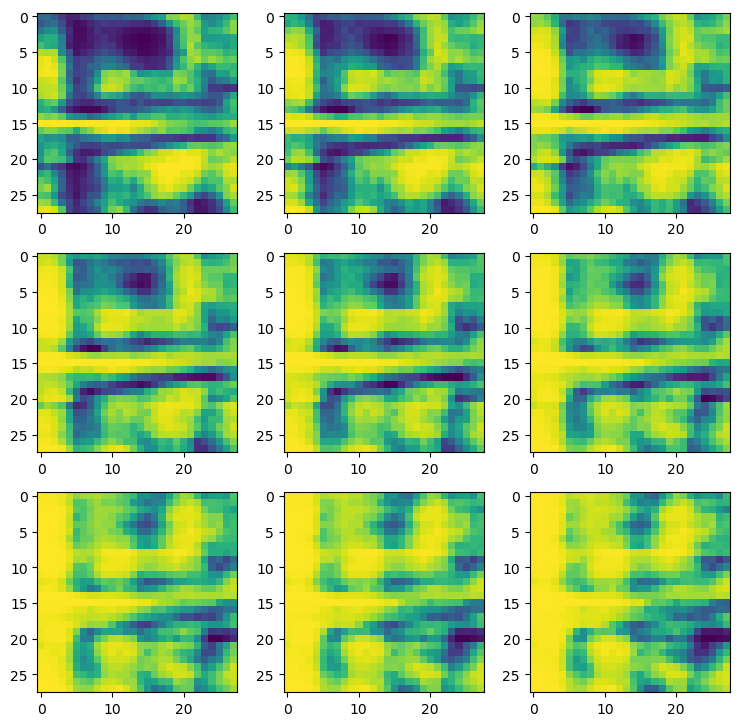

In [2]:
# Visualize the results
def save_images(x, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi.reshape(28, 28))
    fig.savefig(filename)

model = net.MyCVAE(784, NZDIM, 500, NLABELDIM)
serializers.load_npz("mymodel_final.npz", model)

# draw images from randomly sampled z
z = chainer.Variable(np.random.normal(0, 1, (9, NZDIM)).astype(np.float32))
z = chainer.Variable(np.zeros((9, NZDIM), dtype=np.float32))


#values = np.eye(NLABELDIM, dtype=np.float32)[range(9)]
#pos = np.linspace(0.05, 0.85, 9, dtype=np.float32)
pos = np.linspace(0.1, 0.9, 9, dtype=np.float32)
print(pos)
labels = pos * NLABELDIM

labels = labels.astype(dtype=np.int32)
#values = np.eye(NLABELDIM, dtype=np.float32)[labels]     # one hot vector
values = np.linspace(0.1, 0.9, 9, dtype=np.float32)       # label and coordinate

x = model.decode(z, np.expand_dims(values, axis=1))
save_images(x.data, 'sampled')

In [3]:
#!/usr/bin/env python
"""Chainer example: train a VAE on MNIST
"""
import argparse
import os

import chainer
from chainer import training
from chainer.training import extensions
import numpy as np

import net
import make_random_mnist
import pickle

def load_random_dataset_nolabel():
    with open('random_dataset.pickle', mode='rb') as f:
        ret = pickle.load(f)
        return ret

def save_random_dataset_nolabel( v):
    with open('random_dataset.pickle', mode='wb') as f:
        pickle.dump(v, f)
        
def main():
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=100, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=20, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=1200,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args = ['-g 0'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')

    # Prepare VAE model, defined in net.py
    model = net.VAE(784, args.dimz, 2000)

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if args.initmodel:
        chainer.serializers.load_npz(args.initmodel, model)

    # Load the MNIST dataset
    train, test = chainer.datasets.get_mnist(withlabel=False)
    dataset = make_random_mnist.MakeRandomMNIST()
    #train = dataset.get_random_dataset_nolabel(60000)
    #save_random_dataset_nolabel(train)
    train = load_random_dataset_nolabel()
    print(train.shape)

    if args.test:
        train, _ = chainer.datasets.split_dataset(train, 100)
        test, _ = chainer.datasets.split_dataset(test, 100)

    train_iter = chainer.iterators.SerialIterator(train, args.batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args.batchsize,
                                                 repeat=False, shuffle=False)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer,
        device=args.gpu, loss_func=model.get_loss_func())
    #updater = training.updaters.ParallelUpdater(train_iter, optimizer, devices={'main': 0, 'second': 1})

    trainer = training.Trainer(updater, (args.epoch, 'epoch'), out=args.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu,
                                        eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(args.epoch, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    #trainer.extend(extensions.ProgressBar())

    if args.resume:
        chainer.serializers.load_npz(args.resume, trainer)

    # Run the training
    trainer.run()

    # Visualize the results
    def save_images(x, filename):
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
        for ai, xi in zip(ax.flatten(), x):
            ai.imshow(xi.reshape(28, 28))
        fig.savefig(filename)

    model.to_cpu()
    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    x = chainer.Variable(np.asarray(train[train_ind]))
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x1 = model.decode(model.encode(x)[0])
    save_images(x.data, os.path.join(args.out, 'train'))
    save_images(x1.data, os.path.join(args.out, 'train_reconstructed'))

    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    x = chainer.Variable(np.asarray(test[test_ind]))
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x1 = model.decode(model.encode(x)[0])
    save_images(x.data, os.path.join(args.out, 'test'))
    save_images(x1.data, os.path.join(args.out, 'test_reconstructed'))

    # draw images from randomly sampled z
    z = chainer.Variable(
        np.random.normal(0, 1, (9, args.dimz)).astype(np.float32))
    x = model.decode(z)
    save_images(x.data, os.path.join(args.out, 'sampled'))


if __name__ == '__main__':
    main()


GPU: 0
# dim z: 20
# Minibatch-size: 1200
# epoch: 100



FileNotFoundError: [Errno 2] No such file or directory: 'random_dataset.pickle'